## Finding best policies in simple MDPs

We'll use the simplest RL techniques - Policy and Value iteration to find the best policies (which maximize the discounted total reward) in our MDPs from the Frozen Lake Environment.

## Frozen Lake

Let's now try to solve the Frozen Lake environment for some cases

Let us consider an unusual $\gamma = 1$.

In [1]:
pip install gymnasium

   ---------------------------------------- 0.0/952.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/952.1 kB ? eta -:--:--
   ---------------------- ----------------- 524.3/952.1 kB 1.5 MB/s eta 0:00:01
   --------------------------------- ------ 786.4/952.1 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 952.1/952.1 kB 1.6 MB/s  0:00:00

   ------------- -------------------------- 1/3 [cloudpickle]
   -------------------------- ------------- 2/3 [gymnasium]
   -------------------------- ------------- 2/3 [gymnasium]
   -------------------------- ------------- 2/3 [gymnasium]
   -------------------------- ------------- 2/3 [gymnasium]
   -------------------------- ------------- 2/3 [gymnasium]
   -------------------------- ------------- 2/3 [gymnasium]
   -------------------------- ------------- 2/3 [gymnasium]
   -------------------------- ------------- 2/3 [gymnasium]
   -------------------------- ------------- 2/3 [gymnasium]
   ---------------

In [2]:
import gymnasium as gym
import numpy as np
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import matplotlib.pyplot as plt
import numpy as np

Function to map state numbers to 2D coordinates (example for a grid)

In [ ]:
def state_to_coordinates(state, grid_size):
    return (state % grid_size[1], state // grid_size[1])

Next, we import out MDP that we are going to work with and just visualize the same

In [ ]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
env = env.unwrapped
mdp_transitions = env.P
init_state = env.reset()
goal_state = 15

print(mdp_transitions)

{0: {0: [(0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 4, 0.0, False)], 1: [(0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 4, 0.0, False), (0.3333333333333333, 1, 0.0, False)], 2: [(0.3333333333333333, 4, 0.0, False), (0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False)], 3: [(0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 0, 0.0, False)]}, 1: {0: [(0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 5, 0.0, True)], 1: [(0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 5, 0.0, True), (0.3333333333333333, 2, 0.0, False)], 2: [(0.3333333333333333, 5, 0.0, True), (0.3333333333333333, 2, 0.0, False), (0.3333333333333333, 1, 0.0, False)], 3: [(0.3333333333333333, 2, 0.0, False), (0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False)]}, 2: {0: [(0.3333333333333333, 2, 0.0, False), (0.3333333333333333

Further, we start by writing a random policy, that we will iterate upon

In [ ]:
LEFT, DOWN, RIGHT, UP = range(4)
pi = {
    0:RIGHT, 1:RIGHT, 2:DOWN, 3:LEFT,
    4:DOWN, 5:LEFT, 6:DOWN, 7:LEFT,
    8:RIGHT, 9:RIGHT, 10:DOWN, 11:LEFT,
    12:LEFT, 13:RIGHT, 14:RIGHT, 15:LEFT
}

print(pi)
# Or you can do it randomly
# pi = dict()
# for state in mdp:
#     pi[state] = np.random.choice(mdp[state].keys())

{0: 2, 1: 2, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 0, 8: 2, 9: 2, 10: 1, 11: 0, 12: 0, 13: 2, 14: 2, 15: 0}


And a random value function for this random policy, which will be optimized upon

In [ ]:
val = dict()
for state in mdp_transitions:
    val[state] = np.random.random()

# Since 5, 7, 11, 12 and 15 are terminal states, we know their values are 0

val[5] = 0
val[7] = 0
val[11] = 0
val[12] = 0
val[15] = 0

#Or you could do it randomly, remember to set the terminal states to 0. You can also implement this while evaluating the value function using
# val = dict()
# for state in mdp:
#     val[state] = np.random.random()
#     if mdp[state][0][0][0] == 0: # if the first action in the first outcome of the first state is 0, then it is a terminal state
#         val[state] = 0

#instead of doing thsi you can simply intialize the value function to 0 for all states
# for state in swf_mdp:
#   val[state] = 0

The function to generate a new value function from a previous one

In [ ]:
def get_new_value_fn(val, mdp, pi, gamma=1.0):
    new_val = val.copy()

    for state, actions in mdp.items():
        action = list(actions.keys())[pi[state]]  # Get the action based on the policy
        transitions = actions[action]  # Get transitions for the action
        v = 0
        for prob, next_state, reward, done in transitions:
            v += prob * (reward + gamma * val[next_state] * (not done))
        new_val[state] = v  # Update the value for the state

    return new_val

The function to evaluate the policy, and also print the number of iterations it took to convergence

In [ ]:
def policy_evaluation(val, mdp, pi, epsilon=1e-10, gamma=1.0):
    count = 0

    new_val=get_new_value_fn(val, mdp, pi, gamma)
    while np.max(np.abs(np.array(list(val.values())) - np.array(list(new_val.values())))) > epsilon:
        val = new_val
        new_val=get_new_value_fn(val, mdp, pi, gamma)
        count += 1

    return val, count

Function to perform policy improvement using the policy and the value function and return a new policy

In [ ]:
def policy_improvement(val, mdp, pi, gamma=1.0):
    q = {state: {} for state in mdp}  # Nested dictionary for Q-values
    new_pi = {}  # Explicitly initialize new_pi

    # Iterate over all states and actions
    for state, actions in mdp.items():
        for action, transitions in actions.items():
            q_value = 0
            for prob, next_state, reward, done in transitions:
                q_value += prob * (reward + gamma * val[next_state] * (not done))
            q[state][action] = q_value  # Assign computed Q-value

    # Generate a new policy by choosing the action with the max Q-value
    for state in mdp:
        new_pi[state] = max(q[state], key=q[state].get)

    return new_pi, q


We then use the above functions to get the optimal policy and optimal value function and return the total number of iterations it took to converge, creating a random policy and value function to start with

All of this is done under a function to iterate over policies

In [ ]:
def policy_iteration(mdp, epsilon=1e-10, gamma=1.0):
    pi = dict()
    val = dict()
    count = 0

    pi = {s: np.random.choice(list(mdp[s].keys())) for s in mdp}
    val = {s: 0 for s in mdp}  # Initialize value function to 0 for all states

    while True:
        val, count = policy_evaluation(val, mdp, pi, epsilon, gamma)
        new_pi, _ = policy_improvement(val, mdp, pi, gamma)

        if new_pi == pi:
            break

        pi = new_pi

    return pi, val, count

Next is the function to perform value iteration

In [ ]:
def value_iteration(mdp, gamma=1.0, epsilon=1e-10):
    val = {s: 0 for s in mdp}  # Initialize value function to 0 for all states
    count = 0
    q = {state: {} for state in mdp}  # Nested dictionary for Q-values

    while True:
        delta = 0  # To track the maximum change in value function
        # Iterate over all states and actions
        for state, actions in mdp.items():
            for action, transitions in actions.items():
                q_value = 0
                # Compute Q-value for each action
                for prob, next_state, reward, done in transitions:
                    q_value += prob * (reward + gamma * val[next_state] * (not done))
                q[state][action] = q_value  # Assign computed Q-value

        # Update value function by taking the maximum Q-value for each state
        new_val = {s: max(q[s].values()) for s in mdp}

        # Compute the maximum change (delta) in the value function
        delta = max(delta, max(abs(val[s] - new_val[s]) for s in mdp))

        count += 1

        # If the maximum change in value function is less than epsilon, break
        if delta < epsilon:
            break

        # Update the value function
        val = new_val

    # Generate the optimal policy based on the Q-values
    pi = {s: max(q[s], key=q[s].get) for s in mdp}

    return pi, val, count

Function to plot the policy and the value functions

In [ ]:
def plot_policy_value(pi, val, mdp, grid_size=(4, 4), title="Policy and Value Function Visualization"):
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot each state in the grid
    for state in range(len(mdp)):
        x, y = state_to_coordinates(state, grid_size)

        # Plot the value function as a color map
        ax.add_patch(plt.Rectangle((x, y), 1, 1, color=plt.cm.viridis(val[state] / max(val.values())), zorder=1))

        # Add state number
        ax.text(x + 0.5, y + 0.5, str(state), color="white", ha="center", va="center", fontsize=12, zorder=2)

        # Plot the action direction for the policy (arrows)
        if pi[state] == 0:  # Right
            ax.arrow(x + 0.5, y + 0.5, 0.4, 0, head_width=0.1, head_length=0.1, fc='red', ec='red', zorder=3)
        elif pi[state] == 1:  # Down
            ax.arrow(x + 0.5, y + 0.5, 0, -0.4, head_width=0.1, head_length=0.1, fc='red', ec='red', zorder=3)
        elif pi[state] == 2:  # Left
            ax.arrow(x + 0.5, y + 0.5, -0.4, 0, head_width=0.1, head_length=0.1, fc='red', ec='red', zorder=3)
        elif pi[state] == 3:  # Up
            ax.arrow(x + 0.5, y + 0.5, 0, 0.4, head_width=0.1, head_length=0.1, fc='red', ec='red', zorder=3)

    # Set grid size and labels
    ax.set_xlim(0, grid_size[1])
    ax.set_ylim(0, grid_size[0])
    ax.set_xticks(np.arange(grid_size[1] + 1))
    ax.set_yticks(np.arange(grid_size[0] + 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal', 'box')

    # Display color bar for value function
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=min(val.values()), vmax=max(val.values())))
    sm.set_array([])
    plt.colorbar(sm, ax=ax, fraction=0.02, pad=0.04)

    plt.title(title)
    plt.show()

Test policy to return the % success of the policy

In [ ]:
def test_policy(pi, mdp, goalstate, num_tests=100, max_steps=100):
    successes = 0

    for _ in range(num_tests):
        current_state = np.random.choice(list(mdp.keys()))  # Random start state
        run_reward = 0  # Initialize reward for the current run

        for _ in range(max_steps):
            if current_state == goalstate:  # Goal reached
                successes += 1
                break

            # Get the action for the current state
            action = pi.get(current_state, None)
            if action is None:  # If no action is defined, stop
                break

            # Perform the action and transition
            transitions = mdp[current_state][action]
            probs, next_states, rewards, dones = zip(*transitions)
            next_state = np.random.choice(next_states, p=probs)
            done = dones[0]
            if done:
                break  # Exit if a terminal state is encountered
            current_state = next_state


    success_rate = successes / num_tests
    return successes  # Only return the number of successes

#Trial Environment 1

In [ ]:
env2 = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
env2 = env2.unwrapped
mdp2 = env2.P

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
pi1, val1, count1 = policy_iteration(mdp2)
pi2, val2, count2 = value_iteration(mdp2)

Policy Iteration took 702 iterations to converge
Final Value Function for Policy Iteration:
{0: 0.8235294093675635, 1: 0.8235294085640291, 2: 0.8235294079934693, 3: 0.8235294076974147, 4: 0.8235294095420496, 5: 0.0, 6: 0.5294117629918788, 7: 0.0, 8: 0.8235294098783209, 9: 0.8235294103519006, 10: 0.7647058811069277, 11: 0.0, 12: 0.0, 13: 0.88235294017329, 14: 0.9411764700677003, 15: 0.0}


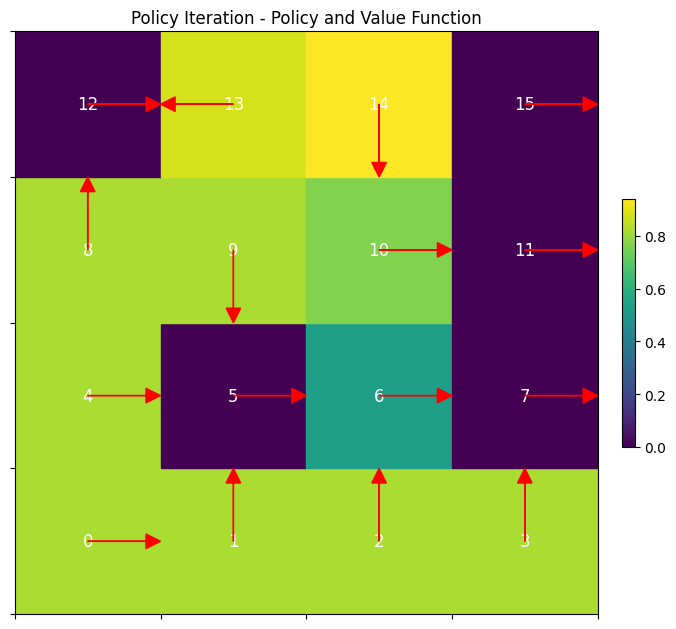

Value Iteration took 806 iterations to converge
Final Value Function for Value Iteration:
{0: 0.8235294093738184, 1: 0.8235294085723809, 2: 0.82352940800331, 3: 0.8235294077080278, 4: 0.823529409547849, 5: 0.0, 6: 0.5294117629963512, 7: 0.0, 8: 0.823529409883243, 9: 0.823529410355587, 10: 0.764705881110179, 11: 0.0, 12: 0.0, 13: 0.8823529401759076, 14: 0.9411764700690586, 15: 0.0}


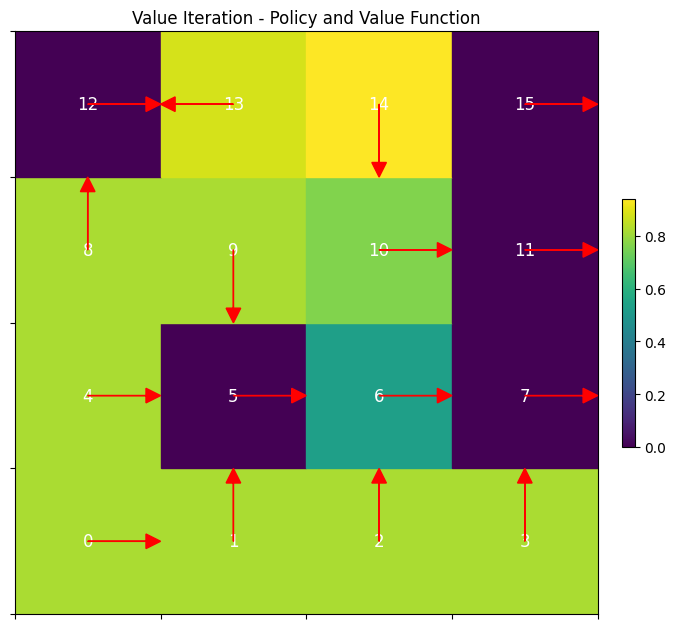

In [ ]:
# Plot for policy iteration results
print(f"Policy Iteration took {count1} iterations to converge")
print("Final Value Function for Policy Iteration:")
print(val1)
plot_policy_value(pi1, val1, mdp2, title="Policy Iteration - Policy and Value Function")

# Plot for value iteration results
print(f"Value Iteration took {count2} iterations to converge")
print("Final Value Function for Value Iteration:")
print(val2)
plot_policy_value(pi2, val2, mdp2, title="Value Iteration - Policy and Value Function")

Note: The states 5,7,11,12,15 are just holes, any action on them doesnt make sense since they will just transition to themselves and will never lead to any goal. So, we randomly have any action on them.

Comparing the differences between the two methods- Policy iteration and Value Iteration

In [ ]:
diff = {state: abs(val1[state] - val2[state]) for state in val1}
print(f"Difference between Value Iteration and Policy Iteration Value Functions: {diff}")

Difference between Value Iteration and Policy Iteration Value Functions: {0: 6.2548854984356694e-12, 1: 8.351763725045203e-12, 2: 9.84068382337e-12, 3: 1.0613177003904184e-11, 4: 5.79947201373443e-12, 5: 0.0, 6: 4.472422432399981e-12, 7: 0.0, 8: 4.922062757373169e-12, 9: 3.68638453096537e-12, 10: 3.251288127614771e-12, 11: 0.0, 12: 0.0, 13: 2.6175728251587316e-12, 14: 1.3582468483264165e-12, 15: 0.0}


In [ ]:
goal_state = 15  # Assuming this is the terminal state
num_tests = 100

# Test the policy from policy iteration
successes_pi = test_policy(pi1, mdp2, goal_state, num_tests)
print(f"Policy Iteration -> Successes: {successes_pi} %")

# Test the policy from value iteration
successes_vi = test_policy(pi2, mdp2, goal_state, num_tests)
print(f"Value Iteration -> Successes: {successes_vi} %")

Policy Iteration -> Successes: 62 %
Value Iteration -> Successes: 51 %


#Trial Environment 2

In [ ]:
env3 = gym.make('FrozenLake-v1',desc=generate_random_map(size=4))
env3 = env3.unwrapped
mdp3 = env3.P

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
pi1, val1, count1 = policy_iteration(mdp3)
pi2, val2, count2 = value_iteration(mdp3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Policy Iteration took 581 iterations to converge
Final Value Function for Policy Iteration:
{0: 0.33333333012577804, 1: 0.33333333014406974, 2: 0.0, 3: 0.0, 4: 0.3333333304030103, 5: 0.33333333045620017, 6: 0.0, 7: 0.0, 8: 0.33333333061980197, 9: 0.33333333108660135, 10: 0.33333333239080165, 11: 0.0, 12: 0.33333333034442253, 13: 0.0, 14: 0.6666666661726427, 15: 0.0}


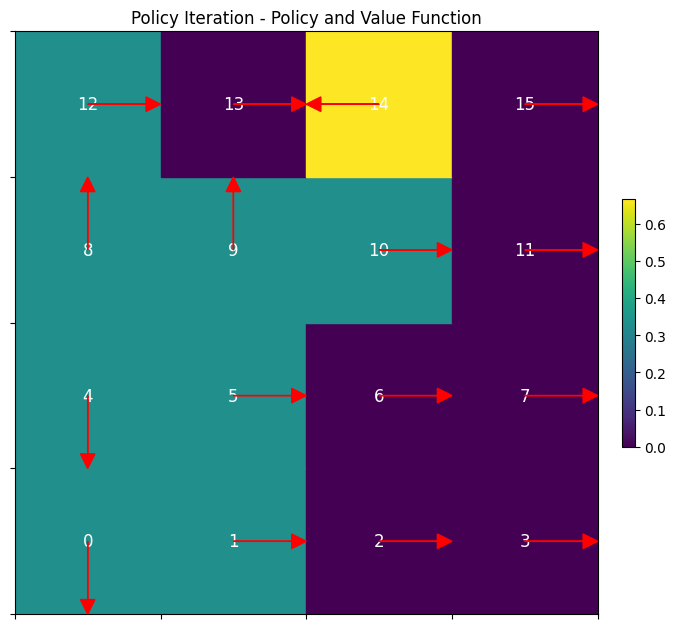

Value Iteration took 600 iterations to converge
Final Value Function for Value Iteration:
{0: 0.333333330115096, 1: 0.3333333301334486, 2: 0.0, 3: 0.0, 4: 0.3333333303932515, 5: 0.3333333304466185, 6: 0.0, 7: 0.0, 8: 0.33333333061076514, 9: 0.3333333310791191, 10: 0.33333333238766283, 11: 0.0, 12: 0.33333333033446866, 13: 0.0, 14: 0.6666666661709975, 15: 0.0}


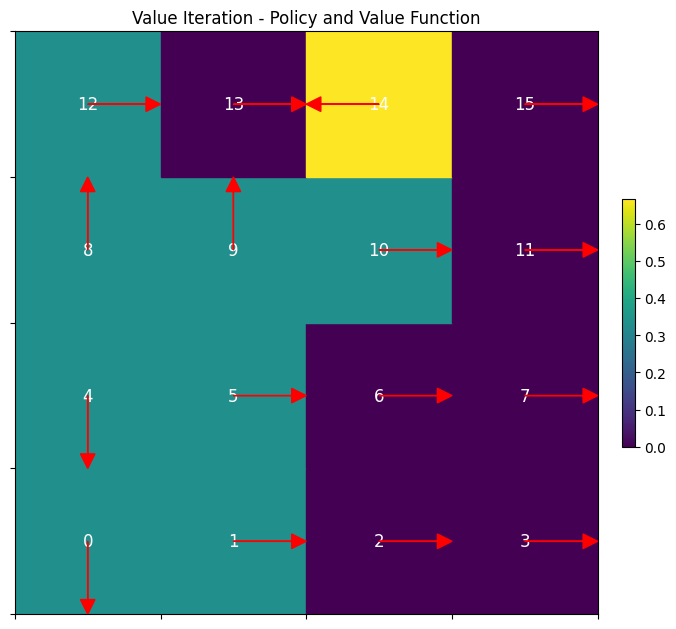

In [ ]:
# Plot for policy iteration results
print(f"Policy Iteration took {count1} iterations to converge")
print("Final Value Function for Policy Iteration:")
print(val1)
plot_policy_value(pi1, val1, mdp3, title="Policy Iteration - Policy and Value Function")

# Plot for value iteration results
print(f"Value Iteration took {count2} iterations to converge")
print("Final Value Function for Value Iteration:")
print(val2)
plot_policy_value(pi2, val2, mdp3, title="Value Iteration - Policy and Value Function")

In [ ]:
num_tests = 100

# Test the policy from policy iteration
successes_pi = test_policy(pi1, mdp2, 15 , num_tests)
print(f"Policy Iteration -> Successes: {successes_pi} %")

# Test the policy from value iteration
successes_vi = test_policy(pi1, mdp2, 15 , num_tests)
print(f"Value Iteration -> Successes: {successes_vi} %")

Policy Iteration -> Successes: 17 %
Value Iteration -> Successes: 14 %


#Trial Environemnt 3

In [ ]:
env4 = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False)
env4 = env4.unwrapped
mdp4 = env4.P
print(mdp4)

{0: {0: [(1.0, 0, 0.0, False)], 1: [(1.0, 4, 0.0, False)], 2: [(1.0, 1, 0.0, False)], 3: [(1.0, 0, 0.0, False)]}, 1: {0: [(1.0, 0, 0.0, False)], 1: [(1.0, 5, 0.0, True)], 2: [(1.0, 2, 0.0, False)], 3: [(1.0, 1, 0.0, False)]}, 2: {0: [(1.0, 1, 0.0, False)], 1: [(1.0, 6, 0.0, False)], 2: [(1.0, 3, 0.0, False)], 3: [(1.0, 2, 0.0, False)]}, 3: {0: [(1.0, 2, 0.0, False)], 1: [(1.0, 7, 0.0, True)], 2: [(1.0, 3, 0.0, False)], 3: [(1.0, 3, 0.0, False)]}, 4: {0: [(1.0, 4, 0.0, False)], 1: [(1.0, 8, 0.0, False)], 2: [(1.0, 5, 0.0, True)], 3: [(1.0, 0, 0.0, False)]}, 5: {0: [(1.0, 5, 0, True)], 1: [(1.0, 5, 0, True)], 2: [(1.0, 5, 0, True)], 3: [(1.0, 5, 0, True)]}, 6: {0: [(1.0, 5, 0.0, True)], 1: [(1.0, 10, 0.0, False)], 2: [(1.0, 7, 0.0, True)], 3: [(1.0, 2, 0.0, False)]}, 7: {0: [(1.0, 7, 0, True)], 1: [(1.0, 7, 0, True)], 2: [(1.0, 7, 0, True)], 3: [(1.0, 7, 0, True)]}, 8: {0: [(1.0, 8, 0.0, False)], 1: [(1.0, 12, 0.0, True)], 2: [(1.0, 9, 0.0, False)], 3: [(1.0, 4, 0.0, False)]}, 9: {0: [(1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
pi1_4, val1_4, count1_4 = policy_iteration(mdp4)
pi2_4, val2_4, count2_4 = value_iteration(mdp4)

Policy Iteration took 0 iterations to converge
Final Value Function for Policy Iteration:
{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 0.0, 6: 1.0, 7: 0.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 0.0, 12: 0.0, 13: 1.0, 14: 1.0, 15: 0.0}


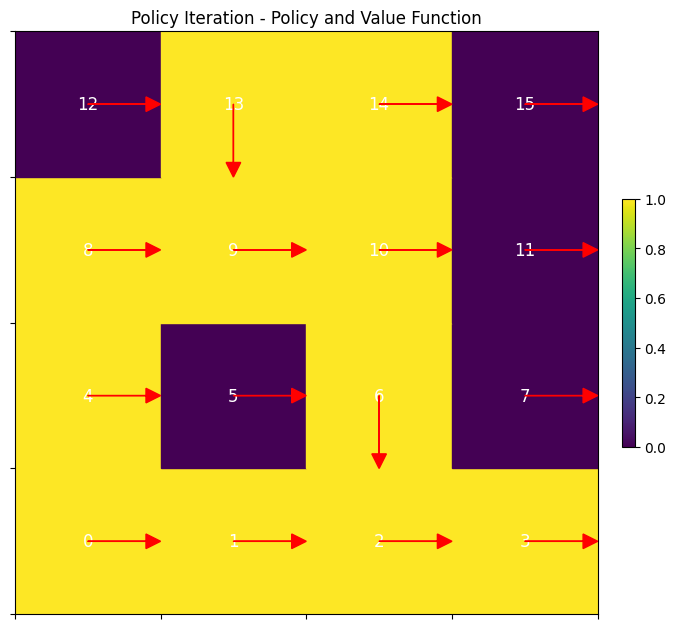

Value Iteration took 7 iterations to converge
Final Value Function for Value Iteration:
{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 0.0, 6: 1.0, 7: 0.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 0.0, 12: 0.0, 13: 1.0, 14: 1.0, 15: 0.0}


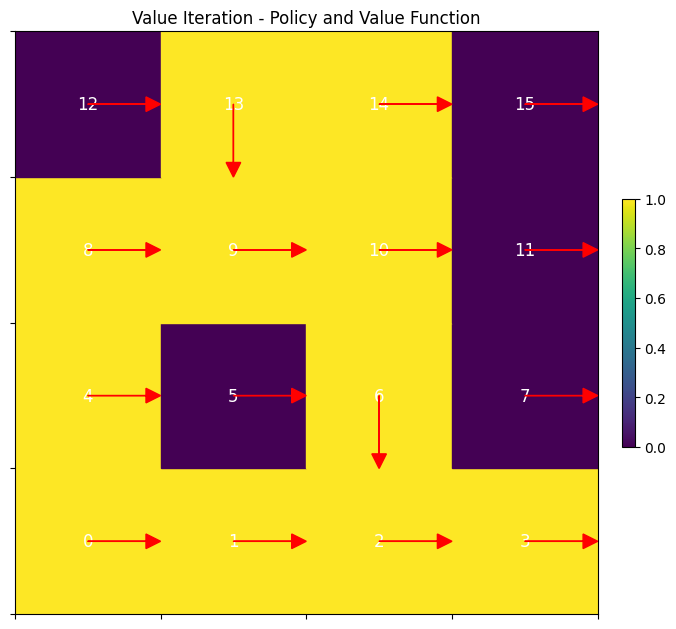

In [ ]:
# Plot for policy iteration results
print(f"Policy Iteration took {count1_4} iterations to converge")
print("Final Value Function for Policy Iteration:")
print(val1_4)
plot_policy_value(pi1_4, val1_4, mdp4, title="Policy Iteration - Policy and Value Function")

# Plot for value iteration results
print(f"Value Iteration took {count2_4} iterations to converge")
print("Final Value Function for Value Iteration:")
print(val2_4)
plot_policy_value(pi2_4, val2_4, mdp4, title="Value Iteration - Policy and Value Function")

In [ ]:
num_tests = 100
# Test the policy from policy iteration
successes_pi = test_policy(pi1_4, mdp4, 15 , num_tests)
print(f"Policy Iteration -> Successes: {successes_pi} %")

# Test the policy from value iteration
successes_vi = test_policy(pi2_4, mdp4, 15 , num_tests)
print(f"Value Iteration -> Successes: {successes_vi} %")

Policy Iteration -> Successes: 4 %
Value Iteration -> Successes: 3 %
